# Feature Extraction Notebook

In this section, we extracted additional features from the original dataset to enhance the predictive power of future models. Feature engineering helps expose hidden patterns, capture temporal and operational dynamics, and make raw data more suitable for machine learning algorithms.

The following types of features were derived:

- **Temporal Features**: 
  - `hour`, `minute`, `weekday`, and `time_index` capture daily and weekly cycles that may influence wind behavior and turbine performance.

- **Wind Direction Components**:
  - `Wdir_sin` and `Wdir_cos` are computed from `Wdir` using trigonometric transformations to represent angular direction in a continuous, model-friendly format.

- **Operational Status Flags**:
  - Boolean indicators such as `is_operating`, `is_idle`, and `is_stopped` provide insight into the turbine's state and help identify inactive or faulty periods.

- **Spatial Features**:
  - `X` and `Y` coordinates were merged from the turbine location file to enable spatial modeling and proximity-based correlation among turbines.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
wtb_df_clean = pd.read_csv("../data/interim/wtbdata_clean.csv")

In [22]:
wtb_df_clean['Timestamp'] = pd.to_datetime(wtb_df_clean['Timestamp'], errors='coerce')

## 1. Time-Based Features

In [23]:
wtb_df_clean['hour'] = wtb_df_clean['Timestamp'].dt.hour
wtb_df_clean['minute'] = wtb_df_clean['Timestamp'].dt.minute
wtb_df_clean['time_index'] = wtb_df_clean['hour'] * 60 + wtb_df_clean['minute']
wtb_df_clean['weekday'] = wtb_df_clean['Timestamp'].dt.weekday

## 2. Wind Direction Encoding

In [24]:
wtb_df_clean['Wdir_rad'] = np.deg2rad(wtb_df_clean['Wdir'])
wtb_df_clean['Wdir_sin'] = np.sin(wtb_df_clean['Wdir_rad'])
wtb_df_clean['Wdir_cos'] = np.cos(wtb_df_clean['Wdir_rad'])

## 3. Operational Status Indicators

In [25]:
wtb_df_clean['is_operating'] = (wtb_df_clean['Wspd'] > 0) & (wtb_df_clean['Patv'] > 0)
wtb_df_clean['is_idle'] = (wtb_df_clean['Wspd'] > 0) & (wtb_df_clean['Patv'] == 0)
wtb_df_clean['is_stopped'] = (wtb_df_clean['Wspd'] == 0)

## 4. Merge Spatial Coordinates from location.csv

In [26]:
location_df = pd.read_csv("../data/raw/turb_location.csv")
wtb_df_clean = wtb_df_clean.merge(location_df, on='TurbID', how='left')

## Final Feature Selection

In [27]:
selected_features = [
    'TurbID', 'Timestamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
    'Pab1', 'Prtv', 'Patv', 'hour', 'minute', 'time_index', 'weekday',
    'Wdir_sin', 'Wdir_cos', 'is_operating', 'is_idle', 'is_stopped',
    'x', 'y'
]

wtb_features = wtb_df_clean[selected_features]

display(wtb_features.head())

,TurbID,Timestamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Prtv,Patv,...,minute,time_index,weekday,Wdir_sin,Wdir_cos,is_operating,is_idle,is_stopped,x,y
0,1,2021-01-01 00:10:00,6.17,-3.99,30.73,41.80,25.92,1.0,-0.25,494.66,...,10,10,4,-0.069582,0.997576,True,False,False,3349.8515,5939.23193
1,1,2021-01-01 00:20:00,6.27,-2.18,30.60,41.63,20.91,1.0,-0.24,509.76,...,20,20,4,-0.038039,0.999276,True,False,False,3349.8515,5939.23193
2,1,2021-01-01 00:30:00,6.42,-0.73,30.52,41.52,20.91,1.0,-0.26,542.53,...,30,30,4,-0.012741,0.999919,True,False,False,3349.8515,5939.23193
3,1,2021-01-01 00:40:00,6.25,0.89,30.49,41.38,20.91,1.0,-0.23,509.36,...,40,40,4,0.015533,0.999879,True,False,False,3349.8515,5939.23193
4,1,2021-01-01 00:50:00,6.10,-1.03,30.47,41.22,20.91,1.0,-0.27,482.21,...,50,50,4,-0.017976,0.999838,True,False,False,3349.8515,5939.23193


In [28]:
wtb_features.to_csv("../data/processed/wtb_features.csv", index=False)

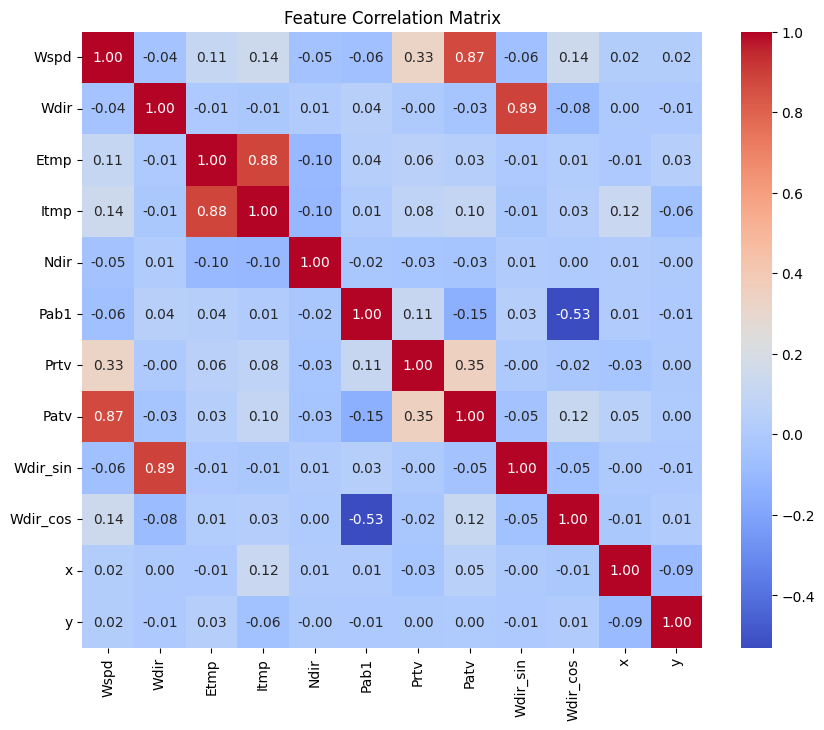

In [29]:
numeric_df = wtb_features.select_dtypes(include=['float64', 'int64']).drop(columns=['TurbID'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()
